In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.auto import trange
from torch.utils.data import Dataset,DataLoader

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()

In [10]:
dataset=pd.read_pickle('/content/integrators_next_state.pickle')

In [11]:
train_set,test_set=train_test_split(dataset,test_size=0.2,random_state=9)
training_set,validation_set=train_test_split(train_set,test_size=0.2,random_state=9)

In [12]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.relu1=nn.ReLU()
        self.h2o = nn.Linear(hidden_size, output_size)
        self.relu2=nn.ReLU()
        self.fc = nn.Linear(output_size, output_size)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden))
        hidden = self.relu1(self.i2h(combined))
        output = self.relu2(self.h2o(hidden))
        output = self.fc(output)
        return output, hidden

    def initHidden(self):
        #return torch.zeros(self.hidden_size).to(device)
        #return torch.rand(self.hidden_size).to(device)
        return torch.rand(self.hidden_size)

In [13]:
EPOCHS   = 200
learning_rate = 0.001 # If you set this too high, it might explode. If too low, it might not learn
momentum=0.9
batch_size=16
regression_loss_function=nn.MSELoss()
classification_loss_function=nn.CrossEntropyLoss()
n_hidden = 12
dimension=training_set[0][0].size(0)
rnn = RNN(dimension,n_hidden,dimension)
#rnn.to(device)
optimizer=optim.SGD(rnn.parameters(),learning_rate)

In [14]:
training_losses=[]
validation_losses=[]

training_losses_class=[]
validation_losses_class=[]

training_losses_reg=[]
validation_losses_reg=[]




for epoch in trange(EPOCHS, desc="Training epoch"):

  rnn.train()

  for batch_start in range(0, len(training_set), batch_size):
    batch_end = min(batch_start + batch_size, len(training_set))
    batch_traces = training_set[batch_start:batch_end]

    optimizer.zero_grad()

    for trace in batch_traces:
      hidden = rnn.initHidden()
      for i in range(len(trace) - 1):
        output, hidden = rnn(trace[i], hidden)
        hidden = hidden.clone().detach()

        # Calculate losses for regression and classification
        regression_output=output[:4]
        regression_correct=trace[i+1][:4]

        classification_output=output[4:]
        classification_correct=trace[i+1][4:]


        loss_regression = regression_loss_function(regression_output, regression_correct)
        loss_classification = classification_loss_function(classification_output, classification_correct)

        loss = loss_regression + 0.1*loss_classification

        # Accumulate gradients
        loss.backward()

    # Update parameters based on accumulated gradients for the entire batch
    optimizer.step()

  rnn.eval()
  with torch.no_grad():

    training_loss=0
    validation_loss=0

    training_loss_reg=0
    validation_loss_reg=0

    training_loss_class=0
    validation_loss_class=0

    num_elem_training=0
    num_elem_validation=0

    for trace in training_set:
      hidden = rnn.initHidden()
      for i in range(len(trace) - 1):
        output, hidden = rnn(trace[i], hidden)
        hidden = hidden.clone().detach()

        # Calculate losses for regression and classification
        regression_output=output[:4]
        regression_correct=trace[i+1][:4]

        classification_output=output[4:]
        classification_correct=trace[i+1][4:]


        loss_regression = regression_loss_function(regression_output, regression_correct).item()
        loss_classification = classification_loss_function(classification_output, classification_correct).item()

        training_loss += loss_regression + 0.1*loss_classification
        training_loss_reg += loss_regression
        training_loss_class += loss_classification
        num_elem_training+=1
    training_losses.append(training_loss/num_elem_training)
    training_losses_reg.append(training_loss_reg/num_elem_training)
    training_losses_class.append(training_loss_class/num_elem_training)


    for trace in validation_set:
      hidden = rnn.initHidden()
      for i in range(len(trace) - 1):
        output, hidden = rnn(trace[i], hidden)
        hidden = hidden.clone().detach()

        # Calculate losses for regression and classification
        regression_output=output[:4]
        regression_correct=trace[i+1][:4]

        classification_output=output[4:]
        classification_correct=trace[i+1][4:]


        loss_regression = regression_loss_function(regression_output, regression_correct).item()
        loss_classification = classification_loss_function(classification_output, classification_correct).item()

        validation_loss += loss_regression + 0.1*loss_classification
        validation_loss_reg += loss_regression
        validation_loss_class += loss_classification
        num_elem_validation+=1
    validation_losses.append(validation_loss/num_elem_validation)
    validation_losses_reg.append(validation_loss_reg/num_elem_validation)
    validation_losses_class.append(validation_loss_class/num_elem_validation)


Training epoch:   0%|          | 0/200 [00:00<?, ?it/s]

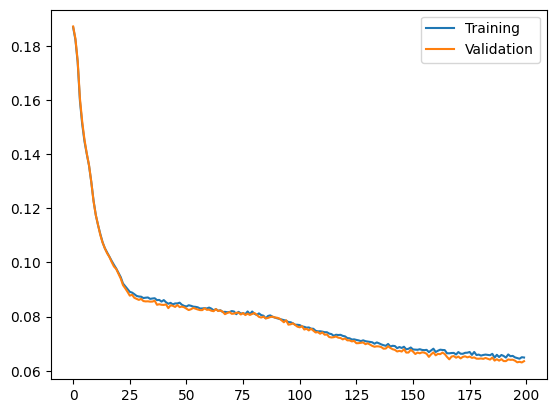

In [15]:
plt.plot(training_losses,label='Training')
plt.plot(validation_losses,label='Validation')
plt.legend()

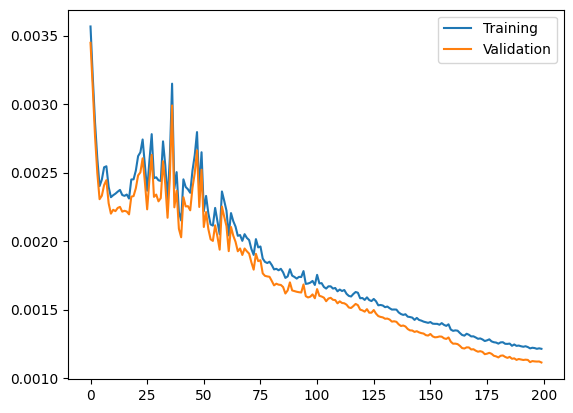

In [16]:
plt.plot(training_losses_reg,label='Training')
plt.plot(validation_losses_reg,label='Validation')
plt.legend()

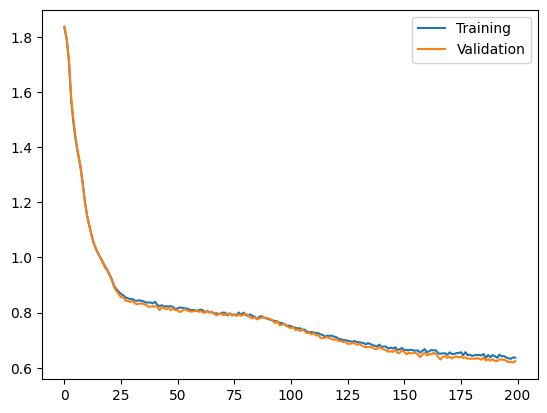

In [17]:
plt.plot(training_losses_class,label='Training')
plt.plot(validation_losses_class,label='Validation')
plt.legend()

In [18]:
def evaluate(nn,trace):
    losses_regression=[]
    correct=0
    hidden = nn.initHidden()
    for i in range(len(trace)-1):
        output,hidden=nn(trace[i],hidden)

        regression_output=output[:4]
        regression_correct=trace[i+1][:4]

        classification_output=torch.argmax(output[4:])
        classification_correct=torch.argmax(trace[i+1][4:])

        loss_regression=regression_loss_function(regression_output,regression_correct)
        losses_regression.append(loss_regression.item())

        if classification_output==classification_correct:
          correct+=1

    return losses_regression,correct


Accuracy is 73.5631138595853%
Mean loss is 0.0011926509029854342


(array([9.394e+03, 9.540e+02, 1.950e+02, 9.900e+01, 6.600e+01, 3.800e+01,
        1.600e+01, 4.000e+01, 2.300e+01, 2.400e+01, 2.000e+01, 1.000e+01,
        1.600e+01, 1.100e+01, 8.000e+00, 8.000e+00, 8.000e+00, 6.000e+00,
        9.000e+00, 6.000e+00, 2.000e+00, 4.000e+00, 5.000e+00, 5.000e+00,
        2.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        3.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

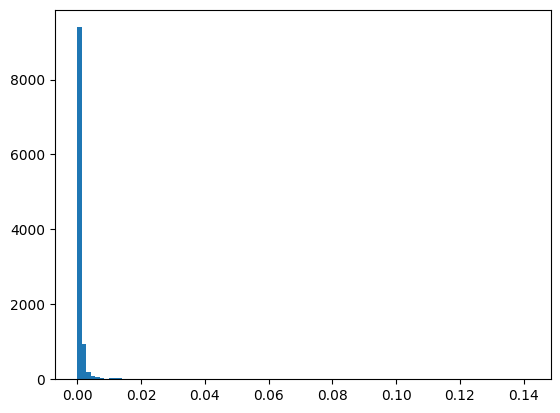

In [19]:
losses=[]
correct=0
tot=0
for trace in test_set:
    trace_losses,trace_correct=evaluate(rnn,trace)
    losses.extend(trace_losses)
    correct+=trace_correct
    tot+=len(trace)-1

print(f"Accuracy is {(correct/tot)*100}%" )
print(f"Mean loss is {np.mean(losses)}")
plt.hist(losses,bins=100)

Accuracy is 73.45290962569929%
Mean loss is 0.001215997124935024


(array([3.2159e+04, 1.1860e+03, 3.8700e+02, 2.2400e+02, 1.5700e+02,
        1.0100e+02, 6.9000e+01, 7.8000e+01, 4.3000e+01, 4.6000e+01,
        3.4000e+01, 1.7000e+01, 1.8000e+01, 2.2000e+01, 1.9000e+01,
        1.0000e+01, 1.3000e+01, 1.0000e+01, 1.1000e+01, 5.0000e+00,
        7.0000e+00, 6.0000e+00, 6.0000e+00, 2.0000e+00, 7.0000e+00,
        2.0000e+00, 2.0000e+00, 0.0000e+00, 4.0000e+00, 3.0000e+00,
        4.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 4.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 4.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00,
        2.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

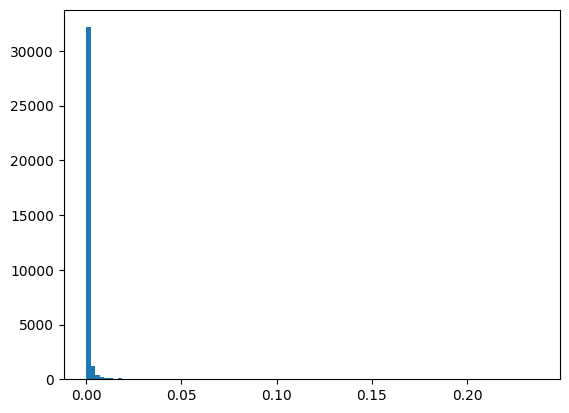

In [20]:
losses=[]
correct=0
tot=0
for trace in training_set:
    trace_losses,trace_correct=evaluate(rnn,trace)
    losses.extend(trace_losses)
    correct+=trace_correct
    tot+=len(trace)-1

print(f"Accuracy is {(correct/tot)*100}%" )
print(f"Mean loss is {np.mean(losses)}")
plt.hist(losses,bins=100)

Accuracy is 72.89309628261371%
Mean loss is 0.0011169349159218217


(array([7.182e+03, 8.260e+02, 2.440e+02, 9.500e+01, 6.300e+01, 4.300e+01,
        2.400e+01, 2.700e+01, 1.300e+01, 1.700e+01, 1.600e+01, 9.000e+00,
        6.000e+00, 7.000e+00, 1.400e+01, 8.000e+00, 7.000e+00, 4.000e+00,
        4.000e+00, 8.000e+00, 2.000e+00, 4.000e+00, 0.000e+00, 4.000e+00,
        2.000e+00, 3.000e+00, 2.000e+00, 5.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00, 2.000e+00, 3.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

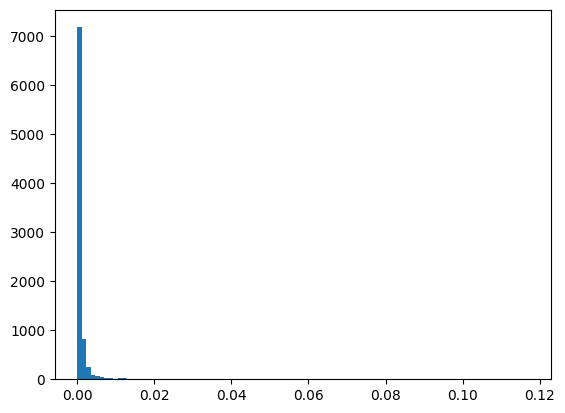

In [21]:
losses=[]
correct=0
tot=0
for trace in validation_set:
    trace_losses,trace_correct=evaluate(rnn,trace)
    losses.extend(trace_losses)
    correct+=trace_correct
    tot+=len(trace)-1

print(f"Accuracy is {(correct/tot)*100}%" )
print(f"Mean loss is {np.mean(losses)}")
plt.hist(losses,bins=100)